# This is my implementation of the paper:
https://arxiv.org/abs/1706.10059

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
from tqdm import tqdm

import math
import plotly.plotly as py
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import timeit

from pylab import rcParams
rcParams['figure.figsize'] = 16, 9

poloniex_train = pd.read_hdf('poloniex_30m.hf', key = 'train')
m = 5
n = 50
f = 3
fee = 0.0025
learning_rate = 3e-5
reg_coeff = 1e-8
nb = 50 #batch size
#training data is from 47 - 43447
#test data is else

In [3]:
poloniex_test = pd.read_hdf('poloniex_30m.hf', 'test')

In [4]:
poloniex = pd.concat([poloniex_train, poloniex_test])
poloniex = poloniex.iloc[12:51112]

In [5]:
def pick_batchstart(t):
    return int(np.round(t*(np.power(-np.random.uniform(), 5)+1), decimals = 0))

In [6]:
#making the X_ts
def createX_t(t, n, data):
    #get n previous points from t
    c_counter, h_counter, l_counter = [0,0,0]
    v_t = np.zeros(shape = (m))
    X_t = np.zeros(shape = (m,n,f))
    
    #generate X_t without division 
    for key in data:
        if key[1] == 'close' and key[0] != 'BTCBTC':
            X_t[c_counter,:,0] = data[key].iloc[t-n:t].as_matrix()
            c_counter += 1
        if key[1] == 'high' and key[0] != 'BTCBTC':
            X_t[h_counter,:,1] = data[key].iloc[t-n:t].as_matrix()
            h_counter += 1
        if key[1] == 'low' and key[0] != 'BTCBTC':
            X_t[l_counter,:,2] = data[key].iloc[t-n:t].as_matrix()
            l_counter += 1
    
    #obtain v_t close
    v_t[:] = X_t[:,n-1,0]
    #produce the final X_t
    for j in range(f):
        for i in range(n):
            X_t[:,i,j] = np.divide(X_t[:,i,j], v_t[:])
    return X_t

def createX1_nb(t,n, data):
    X1_Xnb = np.empty(shape = [nb,m,n,f])
    for i in range(nb):
        X1_Xnb[i,:,:,:] = createX_t(t+i, n, data)
    return X1_Xnb

In [81]:
tf.reset_default_graph()
def port_ai(X1batch, PVMbatch, batch_size):
    inputs_layer = tf.reshape(X1batch, [-1,m,n,f])
    
    #cash bias 
    cash_bias = 0.001*tf.ones(shape = [batch_size, 1], dtype = tf.float32)
    
    #loop to get the weights
    #excluding cash for previous portfolio weights 
    w_0_excash = tf.reshape(tf.slice(PVMbatch, [0, 1], [-1, -1]), [-1,5,1,1])
    #output w's
    w1_nb_output = []
    wsum_output = []
    
    conv1 = tf.layers.conv2d(inputs = inputs_layer, 
                             filters = 2, 
                             kernel_size = [1,3], 
                             padding = 'VALID', 
                             activation = tf.nn.relu,
                             name = 'layer1',
                             kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = reg_coeff))

    conv2 = tf.layers.conv2d(inputs = conv1,
                            filters = 20,
                            kernel_size = [1,48],
                            padding = 'VALID',
                            activation = tf.nn.relu,
                            name = 'layer2',
                            kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = reg_coeff))
    conv2 = tf.concat([conv2,  w_0_excash], axis = 3)
    
    conv3 = tf.layers.conv2d(inputs = conv2,
                            filters = 1,
                            kernel_size = [1,1],
                            padding = 'VALID',
                            activation = tf.nn.relu,
                            name = 'layer3',
                            kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = reg_coeff))

    conv3 = tf.concat([tf.reshape(cash_bias, [batch_size,1,1,1]), conv3], axis = 1)
    w1_nb = tf.nn.softmax(tf.reshape(conv3, [batch_size, m+1]))
    return w1_nb, (tf.get_default_graph()).get_tensor_by_name('layer1/kernel:0')

def r_t(fee, w_0, X_1, w_1):
    #get y_1
    y_1 = tf.slice(X_1, [0,n-2,0], [m,1,1])
    y_1 = tf.div(tf.ones([m, 1, 1]), y_1)
    y_1 = tf.concat([tf.ones([1,1,1]), y_1], axis = 0)
    y_1 = tf.reshape(y_1, [m+1])

    #get mu_t
    y1_mult_w0 = tf.multiply(y_1, w_0)
    y1_dot_w0 = tf.reduce_sum(y1_mult_w0)
    mu_t = trans_cost(fee, 5, y_1 = y_1, y1_dot_w0 = y1_dot_w0, y1_mult_w0 = y1_mult_w0, w_0 = w_0, w_1 = w_1)

    return tf.log(mu_t*y1_dot_w0)

def trans_cost(fee, iterations, y_1, y1_dot_w0, y1_mult_w0, w_0, w_1):
    
    #get w_t'
    w_1_prime = tf.scalar_mul(1/y1_dot_w0,y1_mult_w0)

    mu = fee*(tf.reduce_sum(tf.abs(tf.subtract(tf.slice(w_1_prime, [1], [m]), tf.slice(w_1, [1], [m])))))
    for i in range(iterations):
        sumterm = tf.reduce_sum(tf.nn.relu(tf.subtract(w_1_prime,mu*w_1)))

        mu = (1/(1-fee*w_1[0])) * ((1-fee*w_1_prime[0]) - (2*fee - tf.square(fee))*sumterm)
    return mu

In [78]:
X1batch = tf.placeholder(shape = [nb,m,n,f], dtype = tf.float32)
PVMbatch = tf.placeholder(shape = [nb,m+1], dtype = tf.float32)

w1_nb, weight1 = port_ai(X1batch = X1batch, PVMbatch = PVMbatch, batch_size = nb)
reward = 0

for i in tqdm(range(nb)):
    reward += r_t(fee = fee, w_0 = PVMbatch[i], X_1 = X1batch[i], w_1 = w1_nb[i])
    
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize((-1/nb)*reward)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.07it/s]


In [79]:
saver = tf.train.Saver()

In [12]:
t_f = 51100-1440
t_start = t_f - 10000
PVM = np.float32(np.random.uniform(size = [10000+1, m+1]))
PVM[:,:] = [1.0, 0, 0, 0, 0, 0]

In [14]:
rewards = []
w1_nbs = []
reward_out = 0
weight1_outs = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for steps in tqdm(range(20000)):
        t = np.random.randint(n+1,t_f-t_start-n)
        _, reward_out, w1_nb_out, weight1_out = sess.run([optimizer, reward, w1_nb, weight1], feed_dict = {X1batch:createX1_nb(t,n, poloniex.iloc[t_start:t_f]), PVMbatch:PVM[t-1-n:t-1,:]})
        weight1_outs.append(weight1_out)
        rewards.append(reward_out)
        PVM[t-n:t] = w1_nb_out
    save_path = saver.save(sess, "./tmp/model.ckpt")
    print("Model saved in file: %s" % save_path)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [59:04<00:00,  5.64it/s]


Model saved in file: ./tmp/model.ckpt


this is trained weights

In [41]:
weight1_outs

[array([[[[-0.60143834, -0.35726413],
          [ 0.23276418,  0.39775914],
          [ 0.42259258, -0.00423914]],
 
         [[ 0.47854072, -0.03641027],
          [-0.31245548, -0.06086165],
          [ 0.21470308, -0.11377794]],
 
         [[-0.10129923,  0.03761327],
          [ 0.3325724 , -0.08998507],
          [-0.0657385 ,  0.58860439]]]], dtype=float32),
 array([[[[-0.60146832, -0.35729411],
          [ 0.23273422,  0.39772916],
          [ 0.42256263, -0.00426912]],
 
         [[ 0.47851077, -0.03644025],
          [-0.31248543, -0.06089163],
          [ 0.21467312, -0.11380792]],
 
         [[-0.10132919,  0.03758329],
          [ 0.33254245, -0.09001505],
          [-0.06576846,  0.58857441]]]], dtype=float32),
 array([[[[-0.60149831, -0.35732412],
          [ 0.23270421,  0.39769915],
          [ 0.42253262, -0.00429913]],
 
         [[ 0.47848076, -0.03647026],
          [-0.31251544, -0.06092163],
          [ 0.21464311, -0.11383792]],
 
         [[-0.1013592 ,  0.03755

# Testing the network

In [18]:
def createX1(t,n, data):
    X1_Xnb = np.empty(shape = [1,m,n,f])
    X1_Xnb[0,:,:,:] = createX_t(t, n, data)
    return X1_Xnb

In [67]:
PVM_test = np.float32(np.random.uniform(size = [51100-45000+1, m+1]))
PVM_test[:,:] = [1.0, 0, 0, 0, 0, 0]

In [82]:
X1batch_test = tf.placeholder(shape = [1,m,n,f], dtype = tf.float32)
PVMbatch_test = tf.placeholder(shape = [1,m+1], dtype = tf.float32)

w1_test, weight1_outs_test = port_ai(X1batch = X1batch_test, PVMbatch = PVMbatch_test, batch_size = 1)
reward_test = r_t(fee = fee, w_0 = PVMbatch_test[0], X_1 = X1batch_test[0], w_1 = w1_test[0])

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, "./tmp/model.ckpt")
    temp_var = sess.run([weight1_outs_test], feed_dict = {X1batch_test:createX1(50,n, poloniex.iloc[45000-50:51100]), PVMbatch_test:PVM_test[0:1]})

In [ ]:
rewards_test = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, "./tmp/model.ckpt")
    for t in tqdm(range(n+1, 51100-45000-50)):
        reward_test_out, w1_test_out = sess.run([reward_test, w1_test], feed_dict = {X1batch_test:createX1(t,n, poloniex.iloc[45000-50:51100]), PVMbatch_test:PVM_test[t-n-1:t-n]})
        PVM_test[t-n] = w1_test_out
        rewards_test.append(reward_test_out)
#         if (t % nb == 0):
#             for _ in range(30):
#                 t_train = np.random.randint(t-50, t)
#             _ = sess.run([optimizer], feed_dict = {X1batch:createX1_nb(t_train,n, poloniex.iloc[45000-50:51100]), PVMbatch:PVM_test[t-n:t+nb-n,:]})

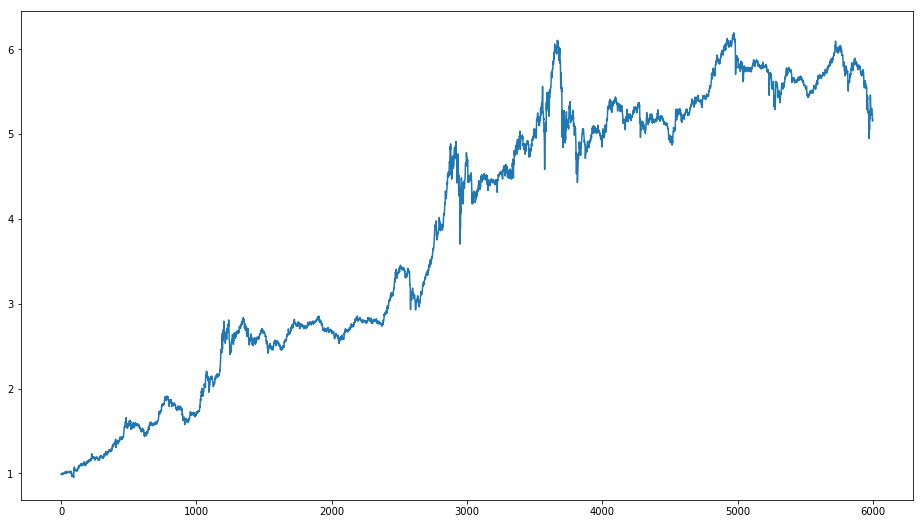

In [19]:
plt.plot(np.exp(np.cumsum(rewards_test)))